# DataJoint for SQL Users

This tutorial maps SQL concepts to DataJoint for users with relational database experience. You'll see:

- How DataJoint syntax corresponds to SQL
- What DataJoint adds beyond standard SQL
- When to use each approach

**Prerequisites:** Familiarity with SQL (SELECT, JOIN, WHERE, GROUP BY).

## Setup

In [1]:
import datajoint as dj

schema = dj.Schema('tutorial_sql_comparison')

[2026-02-19 18:32:27] DataJoint 2.1.1 connected to postgres@postgres:5432


## Schema Definition

### SQL
```sql
CREATE TABLE Researcher (
    researcher_id INT NOT NULL,
    name VARCHAR(100) NOT NULL,
    email VARCHAR(100),
    PRIMARY KEY (researcher_id)
);

CREATE TABLE Subject (
    subject_id INT NOT NULL,
    species VARCHAR(32) NOT NULL,
    sex ENUM('M', 'F', 'unknown'),
    PRIMARY KEY (subject_id)
);

CREATE TABLE Session (
    subject_id INT NOT NULL,
    session_date DATE NOT NULL,
    researcher_id INT NOT NULL,
    notes VARCHAR(255),
    PRIMARY KEY (subject_id, session_date),
    FOREIGN KEY (subject_id) REFERENCES Subject(subject_id),
    FOREIGN KEY (researcher_id) REFERENCES Researcher(researcher_id)
);
```

### DataJoint

In [2]:
@schema
class Researcher(dj.Manual):
    definition = """
    researcher_id : int32
    ---
    name : varchar(100)
    email : varchar(100)
    """

@schema
class Subject(dj.Manual):
    definition = """
    subject_id : int32
    ---
    species : varchar(32)
    sex : enum('M', 'F', 'unknown')
    """

@schema
class Session(dj.Manual):
    definition = """
    -> Subject
    session_date : date
    ---
    -> Researcher
    notes : varchar(255)
    """

### Key Differences

| Aspect | SQL | DataJoint |
|--------|-----|----------|
| Primary key | `PRIMARY KEY (...)` | Above `---` line |
| Foreign key | `FOREIGN KEY ... REFERENCES` | `-> TableName` |
| Types | `INT`, `VARCHAR(n)` | `int32`, `varchar(n)` |
| Table metadata | None | Table tier (`Manual`, `Computed`, etc.) |

## Insert Sample Data

In [3]:
Researcher.insert([
    {'researcher_id': 1, 'name': 'Alice Chen', 'email': 'alice@lab.org'},
    {'researcher_id': 2, 'name': 'Bob Smith', 'email': 'bob@lab.org'},
])

Subject.insert([
    {'subject_id': 1, 'species': 'mouse', 'sex': 'M'},
    {'subject_id': 2, 'species': 'mouse', 'sex': 'F'},
    {'subject_id': 3, 'species': 'rat', 'sex': 'M'},
])

Session.insert([
    {'subject_id': 1, 'session_date': '2024-06-01',
     'researcher_id': 1, 'notes': 'First session'},
    {'subject_id': 1, 'session_date': '2024-06-15',
     'researcher_id': 1, 'notes': 'Follow-up'},
    {'subject_id': 2, 'session_date': '2024-06-10',
     'researcher_id': 2, 'notes': 'Initial'},
    {'subject_id': 3, 'session_date': '2024-06-20',
     'researcher_id': 2, 'notes': 'Rat study'},
])

## Query Comparison

### SELECT * FROM table

In [4]:
# SQL: SELECT * FROM Subject
Subject()

subject_id,species,sex
1,mouse,M
2,mouse,F
3,rat,M


### WHERE — Restriction (`&`)

In [5]:
# SQL: SELECT * FROM Subject WHERE sex = 'M'
Subject & {'sex': 'M'}

subject_id,species,sex
1,mouse,M
3,rat,M


In [6]:
# SQL: SELECT * FROM Subject WHERE species = 'mouse' AND sex = 'F'
Subject & {'species': 'mouse', 'sex': 'F'}

subject_id,species,sex
2,mouse,F


In [7]:
# SQL: SELECT * FROM Session WHERE session_date > '2024-06-10'
Session & "session_date > '2024-06-10'"

subject_id,session_date,researcher_id,notes
1,2024-06-15,1,Follow-up
3,2024-06-20,2,Rat study


### Restriction by Query (Subqueries)

In SQL, you often use subqueries to filter based on another table:

```sql
-- Sessions with mice only
SELECT * FROM Session 
WHERE subject_id IN (SELECT subject_id FROM Subject WHERE species = 'mouse')
```

In DataJoint, you simply restrict by another query — no special subquery syntax needed:

In [8]:
# SQL: SELECT * FROM Session 
#      WHERE subject_id IN (SELECT subject_id FROM Subject WHERE species = 'mouse')

# DataJoint: restrict Session by a query on Subject
mice = Subject & {'species': 'mouse'}
Session & mice

subject_id,session_date,researcher_id,notes
1,2024-06-01,1,First session
1,2024-06-15,1,Follow-up
2,2024-06-10,2,Initial


In [9]:
# Restrict by Alice's sessions (finds subjects she worked with)
alice_sessions = Session & (Researcher & {'name': 'Alice Chen'})
Subject & alice_sessions

subject_id,species,sex
1,mouse,M


## Semantic Matching

A fundamental difference between SQL and DataJoint is **semantic matching** — the principle that attributes acquire meaning through foreign key relationships, and all binary operators use this meaning to determine how tables combine.

### The Problem with SQL

SQL requires you to explicitly specify how tables connect:

```sql
SELECT * FROM Session 
JOIN Subject ON Session.subject_id = Subject.subject_id;
```

This is verbose and error-prone. Nothing prevents you from joining on unrelated columns that happen to share a name, or accidentally creating a Cartesian product when tables have no common columns.

Experienced SQL programmers learn to always join through foreign key relationships. DataJoint makes this the **default and enforced behavior**.

### How Semantic Matching Works

In DataJoint, when you declare a foreign key with `-> Subject`, the `subject_id` attribute in your table inherits its **meaning** from the `Subject` table. This meaning propagates through the foreign key graph.

**Semantic matching** means: all binary operators (`*`, `&`, `-`, `+`, `.aggr()`) match attributes based on shared meaning — those connected through foreign keys. If two tables have no semantically matching attributes, the operation raises an error rather than silently producing incorrect results.

In [10]:
# All these operations use semantic matching on subject_id:

# Join: combines Session and Subject on subject_id
Session * Subject

# Restriction: filters Session to rows matching the Subject query  
Session & (Subject & {'species': 'mouse'})

# Anti-restriction: Session rows NOT matching any Subject (none here, all subjects exist)
Session - Subject

subject_id,session_date,researcher_id,notes


### One Join Operator Instead of Many

SQL has multiple join types (`INNER`, `LEFT`, `RIGHT`, `FULL OUTER`, `CROSS`) because it must handle arbitrary column matching. DataJoint's single join operator (`*`) is sufficient because semantic matching is **more restrictive** than SQL's natural joins:

- SQL natural joins match on **all columns with the same name** — which can accidentally match unrelated columns
- DataJoint semantic joins match only on **attributes connected through foreign keys** — and raise an error if you attempt to join on attributes that shouldn't be joined

This catches errors at query time rather than producing silently incorrect results.

### Algebraic Closure

In standard SQL, query results are just "bags of rows" — they don't have a defined entity type. You cannot know what kind of thing each row represents without external context.

DataJoint achieves **algebraic closure**: every query result is a valid entity set with a well-defined **entity type**. You always know what kind of entity the result represents, identified by a specific primary key. This means:

1. **Every operator returns a valid relation** — not just rows, but a set of entities of a known type
2. **Operators compose indefinitely** — you can chain any sequence of operations
3. **Results remain queryable** — a query result can be used as an operand in further operations

The entity type (and its primary key) is determined by precise rules based on the operator and the functional dependencies between operands. See the [Primary Keys specification](../../reference/specs/primary-keys/) for details.

### SELECT columns — Projection (`.proj()`)

In [11]:
# SQL: SELECT name, email FROM Researcher
Researcher.proj('name', 'email')

researcher_id,name,email
1,Alice Chen,alice@lab.org
2,Bob Smith,bob@lab.org


In [12]:
# SQL: SELECT subject_id, species AS animal_type FROM Subject
Subject.proj(animal_type='species')

subject_id,animal_type
1,mouse
2,mouse
3,rat


### JOIN

In [13]:
# SQL: SELECT * FROM Session JOIN Subject USING (subject_id)
Session * Subject

subject_id,session_date,researcher_id,notes,species,sex
1,2024-06-01,1,First session,mouse,M
1,2024-06-15,1,Follow-up,mouse,M
2,2024-06-10,2,Initial,mouse,F
3,2024-06-20,2,Rat study,rat,M


In [14]:
# SQL: SELECT session_date, name, species 
#      FROM Session 
#      JOIN Subject USING (subject_id) 
#      JOIN Researcher USING (researcher_id)
(Session * Subject * Researcher).proj('session_date', 'name', 'species')

subject_id,session_date,species,name
1,2024-06-01,mouse,Alice Chen
1,2024-06-15,mouse,Alice Chen
2,2024-06-10,mouse,Bob Smith
3,2024-06-20,rat,Bob Smith


### GROUP BY — Aggregation (`.aggr()`)

In [15]:
# SQL: SELECT subject_id, COUNT(*) as num_sessions 
#      FROM Session GROUP BY subject_id
Subject.aggr(Session, num_sessions='count(*)')

subject_id,num_sessions
1,2
2,1
3,1


In [16]:
# SQL: SELECT researcher_id, name, COUNT(*) as num_sessions
#      FROM Researcher JOIN Session USING (researcher_id)
#      GROUP BY researcher_id
Researcher.aggr(Session, num_sessions='count(*)')

researcher_id,num_sessions
1,2
2,2


In [17]:
# SQL: SELECT AVG(...), COUNT(*) FROM Session (no grouping)
dj.U().aggr(Session, total_sessions='count(*)')

total_sessions
4


### NOT IN — Negative Restriction (`-`)

In [18]:
# SQL: SELECT * FROM Subject 
#      WHERE subject_id NOT IN (SELECT subject_id FROM Session)
# (Subjects with no sessions)
Subject - Session

subject_id,species,sex


### Combined Example

In [19]:
# SQL: SELECT r.name, COUNT(*) as mouse_sessions
#      FROM Researcher r
#      JOIN Session s USING (researcher_id)
#      JOIN Subject sub USING (subject_id)
#      WHERE sub.species = 'mouse'
#      GROUP BY r.researcher_id

Researcher.aggr(
    Session * (Subject & {'species': 'mouse'}),
    mouse_sessions='count(*)'
)

researcher_id,mouse_sessions
1,2
2,1


## Operator Reference

| SQL | DataJoint | Notes |
|-----|-----------|-------|
| `SELECT *` | `Table()` | Display table |
| `SELECT cols` | `.proj('col1', 'col2')` | Projection |
| `SELECT col AS alias` | `.proj(alias='col')` | Rename |
| `WHERE condition` | `& {'col': value}` or `& 'expr'` | Restriction |
| `JOIN ... USING` | `Table1 * Table2` | Natural join |
| `GROUP BY ... AGG()` | `.aggr(Table, alias='agg()')` | Aggregation |
| `NOT IN (subquery)` | `Table1 - Table2` | Anti-restriction |
| `UNION` | `Table1 + Table2` | Union |

## What DataJoint Adds

DataJoint is not just "Python syntax for SQL." It adds:

### 1. Table Tiers

Tables are classified by their role in the workflow:

| Tier | Purpose | SQL Equivalent |
|------|---------|----------------|
| `Lookup` | Reference data, parameters | Regular table |
| `Manual` | User-entered data | Regular table |
| `Imported` | Data from external files | Regular table + trigger |
| `Computed` | Derived results | Materialized view + trigger |

### 2. Automatic Computation

Computed tables have a `make()` method that runs automatically. An important principle: **`make()` should only fetch data from upstream tables** — those declared as dependencies in the table definition.

In [20]:
@schema
class SessionAnalysis(dj.Computed):
    definition = """
    -> Session           # depends on Session
    ---
    day_of_week : varchar(10)
    """
    
    def make(self, key):
        # Fetch only from upstream tables (Session and its dependencies)
        date = (Session & key).fetch1('session_date')
        self.insert1({**key, 'day_of_week': date.strftime('%A')})

In [21]:
# Automatically compute for all sessions
SessionAnalysis.populate(display_progress=True)
SessionAnalysis()

SessionAnalysis:   0%|          | 0/4 [00:00<?, ?it/s]

SessionAnalysis: 100%|██████████| 4/4 [00:00<00:00, 331.57it/s]

subject_id,session_date,day_of_week
1,2024-06-01,Saturday
1,2024-06-15,Saturday
2,2024-06-10,Monday
3,2024-06-20,Thursday


In SQL, you'd need triggers, stored procedures, or external scheduling to achieve this.

### 3. Cascading Deletes

DataJoint enforces referential integrity with automatic cascading:

In [22]:
# Deleting a session would delete its computed analysis
# (Session & {'subject_id': 1, 'session_date': '2024-06-01'}).delete()  # Uncomment to try

### 4. Schema as Workflow

The diagram shows the computational workflow, not just relationships:

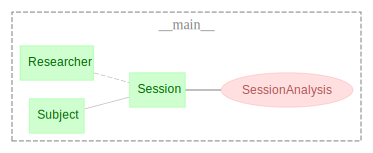

In [23]:
dj.Diagram(schema)

- **Green** = Manual (input)
- **Red** = Computed (derived)
- Arrows show dependency/execution order

### 5. Object Storage Integration

Store large objects (arrays, files) with relational semantics:

```python
class Recording(dj.Imported):
    definition = """
    -> Session
    ---
    raw_data : <blob>       # NumPy array stored in database
    video : <blob@storage>  # Large file stored externally
    """
```

SQL has no standard way to handle this.

## When to Use Raw SQL

DataJoint generates SQL under the hood. Sometimes raw SQL is useful:

In [24]:
# See the generated SQL for any query
query = Session * Subject & {'species': 'mouse'}
print(query.make_sql())

SELECT "subject_id","session_date","researcher_id","notes","species","sex" FROM "tutorial_sql_comparison"."session" JOIN "tutorial_sql_comparison"."subject" USING ("subject_id") WHERE ( ("species"='mouse'))


In [25]:
# Execute raw SQL when needed
# result = dj.conn().query('SELECT * FROM ...')

## Summary

| Feature | SQL | DataJoint |
|---------|-----|----------|
| Query language | SQL strings | Python operators |
| Schema definition | DDL | Python classes |
| Foreign keys | Manual declaration | `->` syntax |
| Table purpose | Implicit | Explicit tiers |
| Automatic computation | Triggers/procedures | `populate()` |
| Large objects | BLOBs (limited) | Codec system |
| Workflow visualization | None | `dj.Diagram()` |

DataJoint uses SQL databases (MySQL/PostgreSQL) underneath but provides:
- **Pythonic syntax** for queries
- **Workflow semantics** for scientific pipelines
- **Automatic computation** via `populate()`
- **Object storage** for large scientific data

In [26]:
# Cleanup
schema.drop(prompt=False)